In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import time
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tests import test_prediction, test_generation
import torch.optim as optim

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print(cuda)
print(device)


True
cuda


In [2]:
# load all that we need

dataset = np.load('../dataset/wiki.train.npy',allow_pickle=True)
fixtures_pred = np.load('../fixtures/prediction.npz',allow_pickle=True)  # dev
fixtures_gen = np.load('../fixtures/generation.npy',allow_pickle=True)  # dev
fixtures_pred_test = np.load('../fixtures/prediction_test.npz',allow_pickle=True)  # test
fixtures_gen_test = np.load('../fixtures/generation_test.npy',allow_pickle=True)  # test
vocab = np.load('../dataset/vocab.npy',allow_pickle=True)

In [3]:
# data loader

class LanguageModelDataLoader(DataLoader):
    """
        TODO: Define data loader logic here
    """
    def __init__(self, dataset, batch_size, shuffle=True):
        #raise NotImplemented
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.sequenceLen = 200


    def __iter__(self):
        # concatenate your articles and build into batches
        #raise NotImplemented
        
        if self.shuffle:
            np.random.shuffle(self.dataset)
        
        dataArray = np.concatenate(self.dataset)
        dataMatrix = torch.LongTensor(dataArray[0:(dataArray.shape[0] // self.sequenceLen) * self.sequenceLen].reshape(dataArray.shape[0] // self.sequenceLen,self.sequenceLen))
        
        i = 0
        while i<dataMatrix.shape[0]:
            batchMatrix = dataMatrix[i:i+self.batch_size]
            i = i + self.batch_size
            inputx = batchMatrix[:,:batchMatrix.size()[1]-1]
            inputy = batchMatrix[:,1:]
            
            yield (inputx,inputy)
            


In [4]:
# model

class LanguageModel(nn.Module):
    """
        TODO: Define your model here
    """
    def __init__(self, vocab_size):
        #raise NotImplemented
        super(LanguageModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, 256)
        self.lstm = nn.LSTM(input_size = 256, hidden_size = 256, num_layers = 3, dropout = 0.2, batch_first=True)
        
        self.linear = nn.Linear(256, vocab_size)
        self.embedding.weight = self.linear.weight
        
        self.embedding.weight.data.uniform_(-0.1,0.1)
        self.linear.bias.data.fill_(0)
        self.linear.weight.data.uniform_(-0.1,0.1)

    def forward(self, x):
        # Feel free to add extra arguments to forward (like an argument to pass in the hiddens)
        #raise NotImplemented
        
        x = self.embedding(x)
        
        x,y = self.lstm(x)
        
        x = x.contiguous()
        
        x = self.linear(x)
        
        return x


In [5]:
# model trainer

class LanguageModelTrainer:
    def __init__(self, model, loader, max_epochs=1, run_id='exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model.to(device)
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.predictions = []
        self.predictions_test = []
        self.generated_logits = []
        self.generated = []
        self.generated_logits_test = []
        self.generated_test = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        
        # TODO: Define your optimizer and criterion here
        #self.optimizer = torch.optim.SGD(self.model.parameters(),lr=5.0,weight_decay=1e-6)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01, weight_decay=1e-6)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,mode="min",factor=0.8,patience=1)

    def train(self):
        self.model.train() # set to training mode
        epoch_loss = 0
        num_batches = 0
        for batch_num, (inputs, targets) in enumerate(self.loader):
            if batch_num % 50 == 0:
                print("batch_num: " , batch_num)
            epoch_loss += self.train_batch(inputs, targets)
        epoch_loss = epoch_loss / (batch_num + 1)
        self.epochs += 1
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss)

    def train_batch(self, inputs, targets):
        """ 
            TODO: Define code for training a single batch of inputs
        
        """
        #raise NotImplemented
        
        self.optimizer.zero_grad()
        
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = self.model(inputs)
        
        loss = self.criterion(outputs.view(-1, outputs.size(2)), targets.contiguous().view(-1))
        
        loss.backward()
        
        self.optimizer.step()
        
        epo_loss = loss.item()
        
        return epo_loss

    
    def test(self):
        # don't change these
        self.model.eval() # set to eval mode
        predictions = TestLanguageModel.prediction(fixtures_pred['inp'], self.model) # get predictions
        self.predictions.append(predictions)
        generated_logits = TestLanguageModel.generation(fixtures_gen, 10, self.model) # generated predictions for 10 words
        generated_logits_test = TestLanguageModel.generation(fixtures_gen_test, 10, self.model)
        nll = test_prediction(predictions, fixtures_pred['out'])
        generated = test_generation(fixtures_gen, generated_logits, vocab)
        generated_test = test_generation(fixtures_gen_test, generated_logits_test, vocab)
        self.val_losses.append(nll)
        
        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)
        
        # generate predictions for test data
        predictions_test = TestLanguageModel.prediction(fixtures_pred_test['inp'], self.model) # get predictions
        self.predictions_test.append(predictions_test)
            
        print('[VAL]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, nll))
        self.scheduler.step(nll)
        return nll

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)
        np.save(os.path.join('experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])


In [6]:
class TestLanguageModel:
    def prediction(inp, model):
        """
            TODO: write prediction code here
            
            :param inp:
            :return: a np.ndarray of logits
        """
        #raise NotImplemented
        inp = torch.LongTensor(inp).to(device)
        model.to(device)
        outputs = model(inp)
        
        return outputs[:, -1, :].detach().cpu().numpy()

        
    def generation(inp, forward, model):
        """
            TODO: write generation code here

            Generate a sequence of words given a starting sequence.
            :param inp: Initial sequence of words (batch size, length)
            :param forward: number of additional words to generate
            :return: generated words (batch size, forward)
        """        
        #raise NotImplemented
        generated_words = []
        inp = torch.LongTensor(inp).to(device)
        model.to(device)
        embedded = model.embedding(inp)
        output_lstm, hidden = model.lstm(embedded)
        scores = model.linear(output_lstm[:, -1, :])
        _, current_word = torch.max(scores, dim=1)
        generated_words.append(current_word)
        
        for i in range(forward-1):
            embedded = model.embedding(current_word).unsqueeze(1)
            output_lstm, hidden = model.lstm(embedded, hidden)
            scores = model.linear(output_lstm[:, -1, :])
            _, current_word = torch.max(scores, dim=1)
            generated_words.append(current_word)
        
        predicts = torch.stack(generated_words).permute(1, 0)
        
        return predicts.detach().cpu().numpy()

In [7]:
# TODO: define other hyperparameters here

NUM_EPOCHS = 999
BATCH_SIZE = 50


In [8]:
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

Saving models, predictions, and generated words to ./experiments/1588481319


In [9]:
model = LanguageModel(len(vocab))
loader = LanguageModelDataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
trainer = LanguageModelTrainer(model=model, loader=loader, max_epochs=NUM_EPOCHS, run_id=run_id)

In [10]:
best_nll = 1e30 
for epoch in range(NUM_EPOCHS):
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch)+" with NLL: "+ str(best_nll))
        trainer.save()
    

batch_num:  0
batch_num:  50
batch_num:  100
batch_num:  150
batch_num:  200
[TRAIN]  Epoch [2/999]   Loss: 7.8459
[VAL]  Epoch [2/999]   Loss: 7.3095
Saving model, predictions and generated output for epoch 0 with NLL: 7.3095293
batch_num:  0
batch_num:  50
batch_num:  100
batch_num:  150
batch_num:  200
[TRAIN]  Epoch [3/999]   Loss: 7.7354
[VAL]  Epoch [3/999]   Loss: 7.0775
Saving model, predictions and generated output for epoch 1 with NLL: 7.077526
batch_num:  0
batch_num:  50
batch_num:  100
batch_num:  150
batch_num:  200
[TRAIN]  Epoch [4/999]   Loss: 7.9196
[VAL]  Epoch [4/999]   Loss: 7.1486
batch_num:  0
batch_num:  50
batch_num:  100
batch_num:  150
batch_num:  200
[TRAIN]  Epoch [5/999]   Loss: 7.4645
[VAL]  Epoch [5/999]   Loss: 6.7180
Saving model, predictions and generated output for epoch 3 with NLL: 6.718029
batch_num:  0
batch_num:  50
batch_num:  100
batch_num:  150
batch_num:  200
[TRAIN]  Epoch [6/999]   Loss: 7.2644
[VAL]  Epoch [6/999]   Loss: 6.5729
Saving mod

batch_num:  50
batch_num:  100
batch_num:  150
batch_num:  200
[TRAIN]  Epoch [40/999]   Loss: 5.2877
[VAL]  Epoch [40/999]   Loss: 5.0334
Saving model, predictions and generated output for epoch 38 with NLL: 5.0333805
batch_num:  0
batch_num:  50
batch_num:  100
batch_num:  150
batch_num:  200
[TRAIN]  Epoch [41/999]   Loss: 5.2662
[VAL]  Epoch [41/999]   Loss: 5.0248
Saving model, predictions and generated output for epoch 39 with NLL: 5.0247993
batch_num:  0
batch_num:  50
batch_num:  100
batch_num:  150
batch_num:  200
[TRAIN]  Epoch [42/999]   Loss: 5.2405
[VAL]  Epoch [42/999]   Loss: 4.9610
Saving model, predictions and generated output for epoch 40 with NLL: 4.96103
batch_num:  0
batch_num:  50
batch_num:  100
batch_num:  150
batch_num:  200
[TRAIN]  Epoch [43/999]   Loss: 5.2181
[VAL]  Epoch [43/999]   Loss: 5.0116
batch_num:  0
batch_num:  50
batch_num:  100
batch_num:  150
batch_num:  200
[TRAIN]  Epoch [44/999]   Loss: 5.1993
[VAL]  Epoch [44/999]   Loss: 4.9767
batch_num: 

KeyboardInterrupt: 

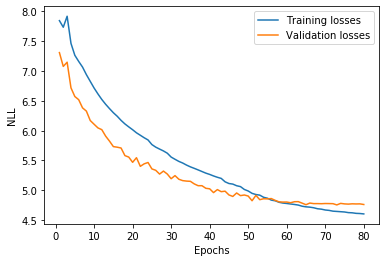

In [11]:
# Don't change these
# plot training curves
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [12]:
# see generated output
print (trainer.generated[-1]) # get last generated output

Input | Output #0: while the group was en route , but only three were ultimately able to attack . None of them were | the first of the first @-@ known to the American
Input | Output #1: <unk> , where he remained on loan until 30 June 2010 . <eol> = = = Return to Manchester United | @-@ = = = <eol> The first leg of the
Input | Output #2: 25 April 2013 , denoting shipments of 500 @,@ 000 copies . <eol> The song became One Direction 's fourth | season in the United States . <eol> = = =
Input | Output #3: , and Bruce R. ) one daughter ( Wendy J. <unk> ) and two grandchildren , died in <unk> , | <unk> , <unk> , <unk> , <unk> , <unk> ,
Input | Output #4: Warrior were examples of this type . Because their armor was so heavy , they could only carry a single | . <eol> = = = = = <eol> = =
Input | Output #5: the embassy at 1 : 49 and landed on Guam at 2 : 23 ; twenty minutes later , Ambassador | , and <unk> . <eol> = = = = =
Input | Output #6: <unk> , $ 96 million USD ) . Damage was heaviest in S